# American Community Survey (PUMS) Wage Analysis

** Sections: **
1. Introduction <br/>
    1.1 Importing Data Files (2018 - 2008) <br/>
    1.2. Initial Data Analysis <br/>
2. Data Selection <br/>
    2.1. Full-Time Detection <br/>
    2.2. Outlier <br/>
3. Feature Transformation <br/>
    3.1. Age Bins <br/>
    3.2. Education Categorization <br/>
    3.3. Occupation Grouping <br/>
    3.4. State Observations <br/>
    3.5. Race <br/>
4. Dataframe Management <br/>
    4.1. Remove Columns <br/>
    4.2. OHE Columns <br/>
5. Preprocessing Pipeline <br/>
6. Modeling <br/>
    6.1. Random Forest <br/>
    6.2. Feature Selection <br/>
7. Analysis <br/>
    7.1. Scoring Rational <br/>
    7.2. Year to Year Analysis <br/>
    7.3. Simple Wage Predictor <br/>


# 1. Introduction
American Community Survey (ACS) Public Use Microdata Sample (PUMS) shows a range of individual information on the US in separate years. Each year's worth of data is recorded in single rows of individuals which represents about one percent of the US population. It is assumed that the over a five-year period, year year's information should cover five percent of the US population.

The information collected covers features from each person such as weight, age, education, housing situation, children and parent status, and more. These areas are all coded to numerical values which out outlined in the data directory which includes all coded values. Full data and documentation can be located at at the [US Census Website](https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.html) for years readily available between 2005 and 2018.

The goal of this information is the accumulate the data from specified features to output a single score which reflects the wage difference between men and females while normalizing for age, education, industry, region, and race. While there are certainly difference between each subsection as to how large the difference is, this score looks to encapsulate the differences for the entire US.

## 1.1. Importing Data Files (2018 - 2008)

These datafiles are large (2 GB for each year) and contain multiple columns which are not observed in this study. Therefore, given the plethora of data, only half of the years (initially only 2018) were visualized and analyzed for creating a model. Overall, columns chosen were assumed to show the most correlation between wage and signs of difference between gender.

In [1]:
# Importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

import statistics
import glob
import time

In [2]:
years = list(r*2 for r in range(1004, 1010))
PUS_start = pd.DataFrame()
start_time = time.time()
for year in years:
    useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
                   'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST', 'HISP']
    path = ('data/%s' % year)
    PUS_split = pd.concat([pd.read_csv(f, usecols=useful_cols)
                           for f in glob.glob(path + "/*.csv")], ignore_index=True)
    PUS_start = PUS_start.append(PUS_split)
print(PUS_start.shape)
print(" %s min" % round(((time.time() - start_time)/60), 2))

(18679015, 11)
 0.46 min


## 1.2. Initial Data Analysis

In [3]:
PUS_start.columns

Index(['ST', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'HISP', 'OCCP',
       'POWSP', 'RAC1P'],
      dtype='object')

In [4]:
PUS_start.describe(include='all')

,ST,AGEP,SCHL,SEX,WAGP,WKHP,WKW,HISP,OCCP,POWSP,RAC1P
count,1.867902e+07,1.867902e+07,1.808252e+07,1.867902e+07,1.593322e+07,1.116149e+07,9.622696e+06,1.867902e+07,1.103743e+07,8.397553e+06,1.867902e+07
mean,2.765467e+01,4.056208e+01,1.585766e+01,1.512292e+00,2.566373e+04,3.284190e+01,1.899983e+00,1.551874e+00,4.340872e+03,2.800783e+01,1.860106e+00
std,1.603227e+01,2.352116e+01,5.660316e+00,4.998489e-01,4.782771e+04,1.798892e+01,1.631469e+00,2.636365e+00,2.620540e+03,1.795425e+01,2.067998e+00
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00
25%,1.200000e+01,2.000000e+01,1.400000e+01,1.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.000000e+00,2.310000e+03,1.200000e+01,1.000000e+00
50%,2.700000e+01,4.100000e+01,1.700000e+01,2.000000e+00,5.000000e+03,4.000000e+01,1.000000e+00,1.000000e+00,4.400000e+03,2.700000e+01,1.000000e+00
75%,4.200000e+01,5.900000e+01,2.000000e+01,2.000000e+00,3.600000e+04,4.000000e+01,2.000000e+00,1.000000e+00,5.740000e+03,4.200000e+01,1.000000e+00
max,5.600000e+01,9.600000e+01,2.400000e+01,2.000000e+00,7.180000e+05,9.900000e+01,6.000000e+00,2.400000e+01,9.920000e+03,5.550000e+02,9.000000e+00


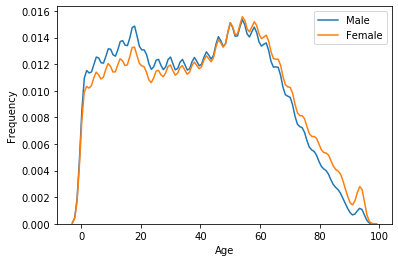

In [5]:
g = sns.kdeplot(
    PUS_start["AGEP"][(PUS_start["SEX"] == 1) & (PUS_start["AGEP"].notnull())])
g = sns.kdeplot(
    PUS_start["AGEP"][(PUS_start["SEX"] == 2) & (PUS_start["AGEP"].notnull())])
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Male", "Female"])

Text(0, 0.5, 'Frequency')

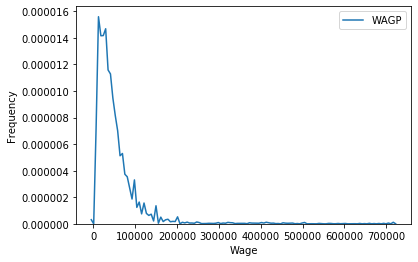

In [6]:
g = sns.kdeplot(PUS_start["WAGP"][(PUS_start["WAGP"] > 0) & (PUS_start["AGEP"] > 18)])
g.set_xlabel("Wage")
g.set_ylabel("Frequency")

# 2. Data Selection
## 2.1. Full-Time Detection

Before analyzing the data, first the scope of people observed were reserved for those working full time and in the general age of retirement. Therefore, after observing the data, and general research, it was decided to only include people who are working more than 40 hours a week and more than 40 weeks per a year. Given that the general weeks worked by a worker in the US is 40 hours a week and 45 weeks in a year.

It was also observed that men generally worked more hours than women, but as seen in the graph below, there doesn't seem to be a significant increase in salary among those who work more hours.

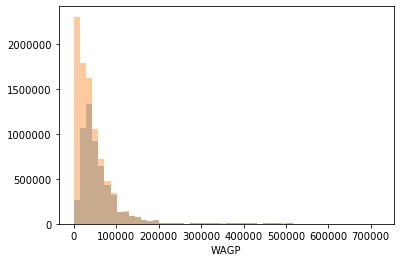

In [7]:
g = sns.distplot(PUS_start["WAGP"][(PUS_start["WAGP"] > 0) & (
    PUS_start["WKW"] < 4) & (PUS_start["WKHP"] >= 40)], kde=False)
g = sns.distplot(PUS_start["WAGP"][(PUS_start["WAGP"] > 0)], kde=False)

In [152]:
# define function to seperate people who've worked more than 40 weeks / year
def full_time_detect(df):
    # remove rows of people who work under 40 weeks in a year
    df = df.loc[df.WKW < 4].copy()
    # remove rows of people who work under 35 hours a week
    df = df.loc[df.WKHP >= 35].copy()
    # remove rows of people below 18 and above 70
    df = df.loc[df.AGEP >= 18].copy()
    df = df.loc[df.AGEP <= 70].copy()
    return df

In [153]:
ft_test = PUS_start.copy()
ft_test = full_time_detect(ft_test)
print(ft_test.shape)

(6373070, 11)


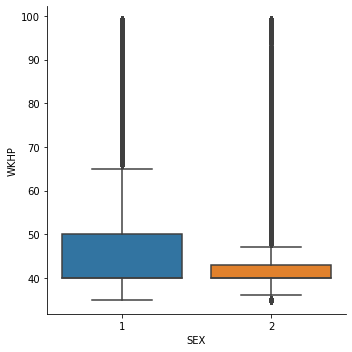

In [154]:
g = sns.catplot(y="WKHP", x="SEX", data=ft_test, kind="box")

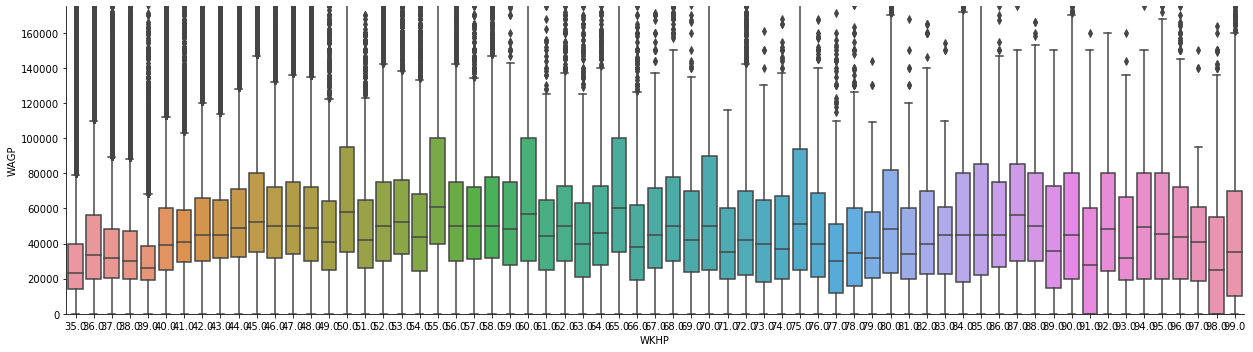

In [155]:
g = sns.catplot(y="WAGP", x="WKHP", data=ft_test, kind="box", aspect=3.5)
g.set(ylim=(0, 175000))

## 2.2. Outlier

Besides full-time workers in the US, outliers in the wage earned were excluded for this study. Quartile sectioning was used in determining significant outliers for the upper end, however the lower end was set at $12,500, the poverty level.

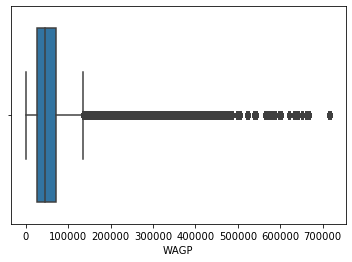

In [12]:
ax = sns.boxplot(x=ft_test["WAGP"])

In [13]:
test_wage_IQR = np.percentile(ft_test.WAGP, 75) - \
    np.percentile(ft_test.WAGP, 25)
test_wage_upper = np.percentile(ft_test.WAGP, 75) + test_wage_IQR*3
test_wage_lower = np.percentile(ft_test.WAGP, 25) - test_wage_IQR*3
print("Wage IQR: ", test_wage_IQR, " Upper: ",
      test_wage_upper, " Lower: ", test_wage_lower)

Wage IQR:  43000.0  Upper:  199000.0  Lower:  -102000.0


In [14]:
def outlier_wage(df):
    # remove rows of outlier upper wages and below poverty $
    wage_IQR = np.percentile(df.WAGP, 75) - np.percentile(df.WAGP, 25)
    wage_upper = np.percentile(df.WAGP, 75) + wage_IQR*3
    df = df.loc[df.WAGP >= 12500].copy()
    df = df.loc[df.WAGP <= wage_upper].copy()
    return df

In [15]:
outlier_test = ft_test.copy()
outlier_test = outlier_wage(outlier_test)
print(outlier_test.shape)

(5216628, 11)


# 3. Feature Transformation
## 3.1. Sex

Race was a difficult subject to separate amongst values due to the majority of those sampled as of white decent. The general split was between Whites, Asians, Blacks. and Others.

In [16]:
def name_sexes(df):
    # split into occupational industries
    df['SEX'] = df['SEX'].map(lambda y: 'Male' if y == 1
                                 else 'Female' if y == 2
                                 else 'na')

    return df

In [17]:
sex_test = outlier_test.copy()
sex_test = name_sexes(sex_test)
print("Sex :", sex_test.SEX.unique())

Sex : ['Male' 'Female']


In [18]:
sex_test['SEX'].value_counts()

Male      3005886
Female    2210742
Name: SEX, dtype: int64

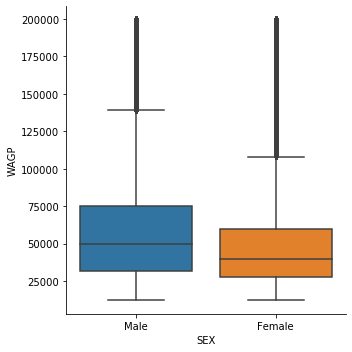

In [19]:
g = sns.catplot(y="WAGP", x="SEX", data=sex_test, kind="box")

## 3.1. Age Bins

As seen in the graph of wage vs age, its seen that there in a steady increase in wages from age 18 to 35 in which it levels out throughout the rest of the years. Therefore, capturing the trends was slightly difficult, so the binning tried to mimic the general trend of this observation. Also, while a further gradient in wages could be a achieved in the initial ages, the sample sizes were relatively small at those level and segmentation of the data would cause issues.
The binning maintained the general trend of the age gaps but show similar ranges for 3 and 4 which was assumed since the wages level out greatly throughout ages past 40. While it can be separated, there might be more relationships between other variables, so the ages were kept split for their large sample size as well.

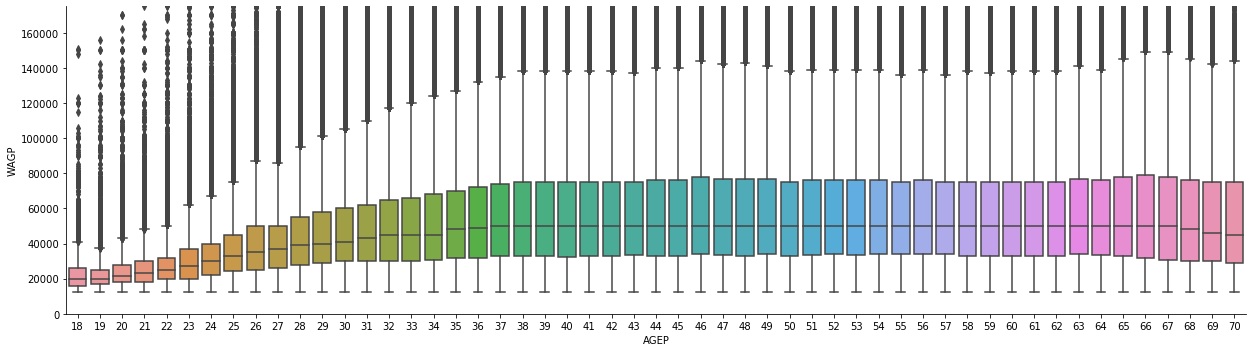

In [20]:
g = sns.catplot(y="WAGP", x="AGEP", data=outlier_test, kind="box", aspect=3.5)
g.set(ylim=(0, 175000))

In [21]:
def age_bins(df):
    df['AGEB'] = df['AGEP'].map(lambda y: '18-25' if y <= 25  # 18-25
                                else '26-35' if y <= 35  # 26-35
                                else '36-45' if y <= 45  # 36-45
                                else '46-55' if y <= 55  # 46-55
                                else '56-70' if y <= 70  # 56-70
                                else 'na')  # +70
    return df

In [22]:
age_test = sex_test.copy()
age_test.sort_values(by=['AGEP'], ascending=True, inplace=True)

In [23]:
age_bins(age_test)
print("Age :", age_test.AGEB.unique())

Age : ['18-25' '26-35' '36-45' '46-55' '56-70']


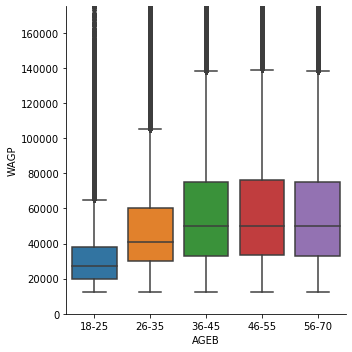

In [24]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test, kind="box")
g.set(ylim=(0, 175000))

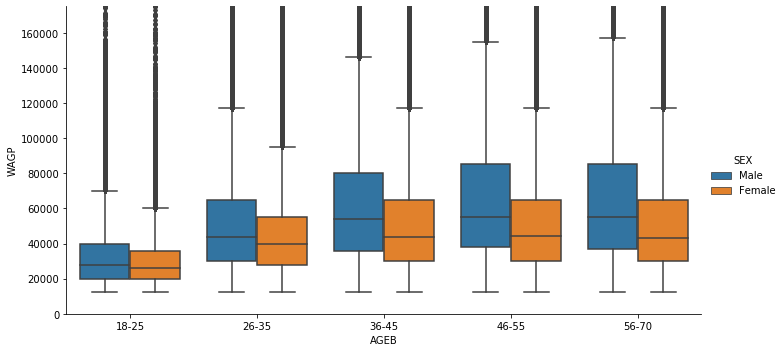

In [25]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test,
                kind="box", aspect=2, hue="SEX")
g.set(ylim=(0, 175000))

In [26]:
age_test['AGEB'].value_counts()

46-55    1391659
36-45    1239567
26-35    1158316
56-70    1040208
18-25     386878
Name: AGEB, dtype: int64

## 3.2. Education Categorization

The education levels were separated out through numerical values coded to separate values. All values 15 and under link to no schooling, preschool, and grades k-12, 16 and 17 are those finishing high school or getting a GED, values above are varying levels of college and graduate school (further details below and in appendix).

Overall, it's observed that the greater the level of education led to greater wage. For those who dropped out of high school there is no specific trends with when the drop out of school, for high school graduates have similar values, and finally those with some college or an associate degree were similar. Higher education showed gradually higher wages.

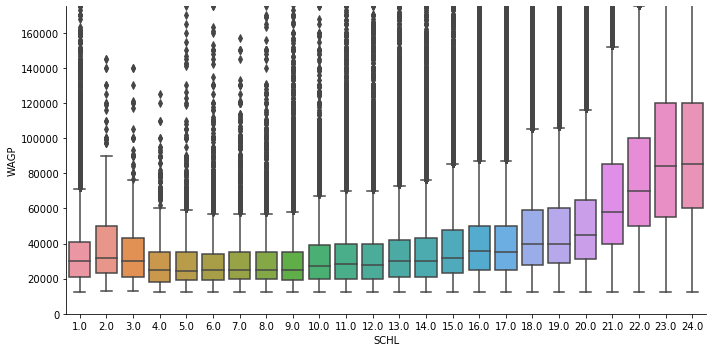

In [27]:
g = sns.catplot(y="WAGP", x="SCHL", data=age_test, kind="box", aspect=2)
g.set(ylim=(0, 175000))

In [28]:
def edu_split(df):
    # split into degrees
    df['EDU'] = df['SCHL'].map(lambda y: 'No_HS' if y <= 15  # didn't finish HS
                               else 'HSD' if y <= 17  # HS degree
                               else 'CLG' if y <= 19  # some college
                               else 'CLG' if y == 20  # AS
                               else 'BS' if y == 21  # BS
                               else 'MS' if y == 22  # MS
                               else 'DR+' if y <= 24  # GS
                               else 'na')
    return df

In [29]:
edu_test = age_test.copy()
edu_test = edu_split(edu_test)
print("Edu :", edu_test.EDU.unique())

Edu : ['HSD' 'CLG' 'No_HS' 'BS' 'MS' 'DR+']


In [30]:
edu_sort = edu_test.groupby('EDU').median(
).sort_values(by=['WAGP']).reset_index()
edu_list = edu_sort['EDU'].tolist()

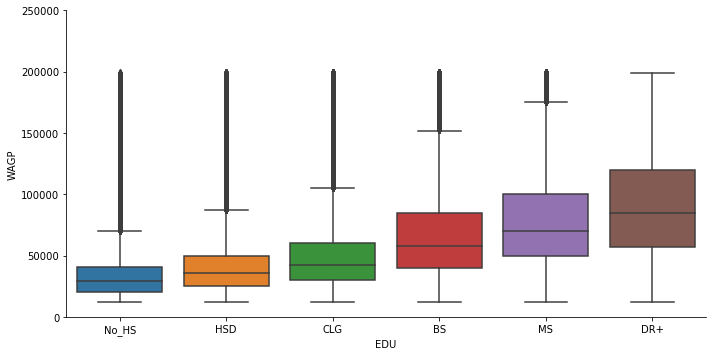

In [31]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test,
                kind="box", aspect=2, order=edu_list)
g.set(ylim=(0, 250000))

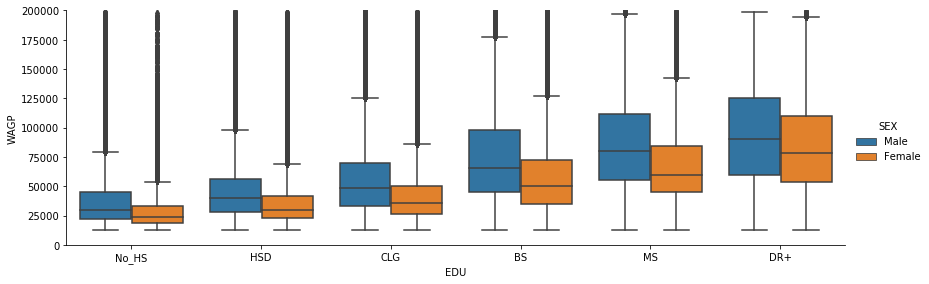

In [32]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test, kind="box",
                height=4, aspect=3, hue="SEX", order=edu_list)
g.set(ylim=(0, 200000))

In [33]:
edu_test['EDU'].value_counts()

CLG      1638229
HSD      1261705
BS       1230774
MS        539844
No_HS     349295
DR+       196781
Name: EDU, dtype: int64

## 3.3. Occupation Grouping

The occupations are sorted by industry and standardized across all years. They are as follows:
- 0010-0960: Management, Business, and Financial Occupations
- 1005-1980: Computer, Engineering, and Science Occupations
- 2001-2970: Education, Legal, Community Service, Arts, and Media Occupations
- 3000-3550: Healthcare Practitioners and Technical Occupations
- 3601-4655: Service Occupations
- 4700-5940: Sales and Office Occupations
- 6005-7640: Natural Resources, Construction, and Maintenance Occupations
- 7700-8990: Production Occupations
- 9005-9760: Transportation and Material Moving Occupations
- 9800-9830: Military Specific Occupations

When observing each industry, there were grouped according to their similarity in wages and how to split their populations. Overall, each of the occupations a wide range of wages that could be affected by other variables such as those who go into business or sciences generally have a higher degree and therefore make more. While these observations are difficult to observe, the general splitting was used to maintain the trend observed.

The grouping is as followed below. Overall, the similar values between each industry was maintained through the grouping of each industry. As observed with all variables before, gender trends between each value show woman are paid less then man.

In [34]:
def occ_split(df):
    # split into occupational industries
    df['JOB'] = df['OCCP'].map(lambda y: "BUS" if y <= 960 #Business
                               else "SCI" if y <= 1980 #Science
                               else "ART" if y <= 2970 #Arts
                               else "HLC" if y <= 3550 #Healthcare
                               else "SVC" if y <= 4655 #Service
                               else "SAL" if y <= 5940 #Sales
                               else "MTN" if y <= 7640 #Maintenance
                               else "PRD" if y <= 8990 #Production
                               else "TRP" if y <= 9760 #Transportation
                               else "MLT" if y <= 9830 #Military
                               else "UN")
    return df

In [35]:
occ_test = edu_test.copy()
occ_test = occ_split(occ_test)
print("Occ :", occ_test.JOB.unique())

Occ : ['MTN' 'SVC' 'BUS' 'SAL' 'SCI' 'PRD' 'TRP' 'HLC' 'ART' 'MLT']


In [36]:
occ_test['JOB'].value_counts()

SAL    1159118
BUS     966283
ART     576643
SVC     575590
MTN     525319
SCI     395275
PRD     386662
TRP     329590
HLC     274677
MLT      27471
Name: JOB, dtype: int64

In [37]:
occ_sort = occ_test.groupby('JOB').median(
).sort_values(by=['WAGP']).reset_index()
occ_list = occ_sort['JOB'].tolist()

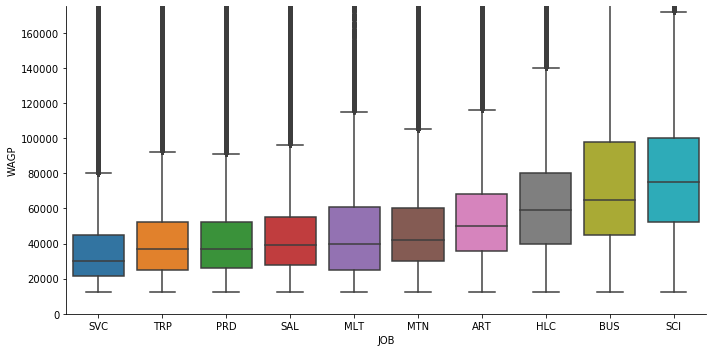

In [38]:
g = sns.catplot(y="WAGP", x="JOB", data=occ_test,
                kind="box", aspect=2, order=occ_list)
g.set(ylim=(0, 175000))

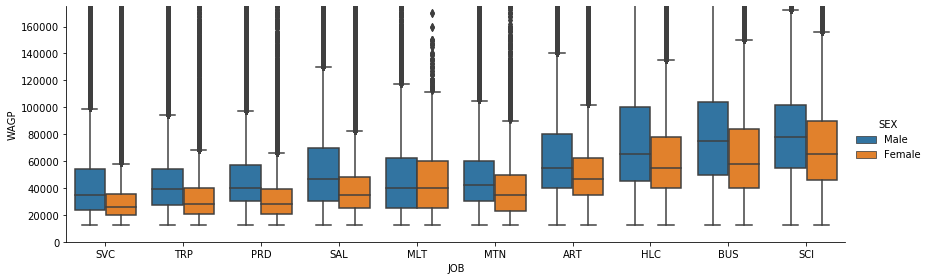

In [39]:
g = sns.catplot(y="WAGP", x="JOB", data=occ_test, kind="box",
                height=4, aspect=3, hue="SEX", order=occ_list)
g.set(ylim=(0, 175000))

## 3.5. Race

Race was a difficult subject to separate amongst values due to the majority of those sampled as of white decent. The general split was between Whites, Asians, Blacks. and Others.

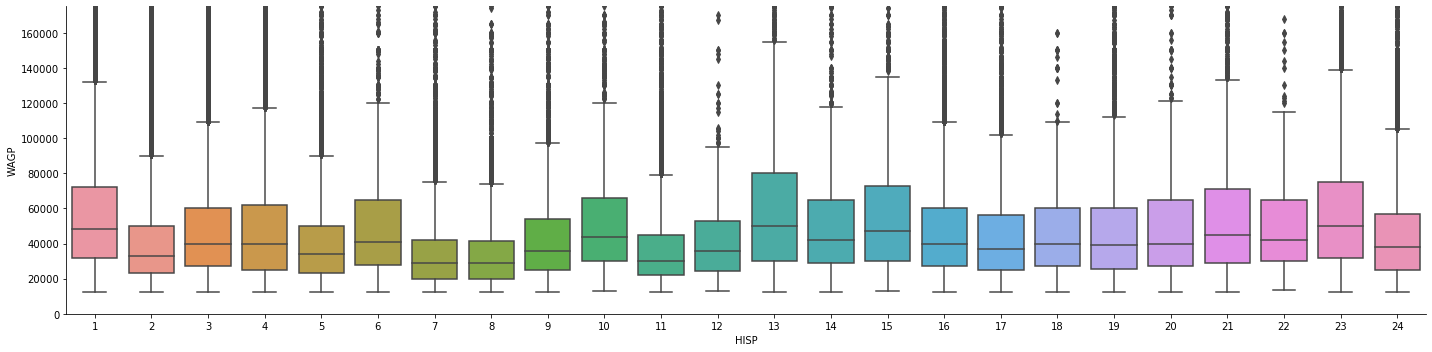

In [40]:
g = sns.catplot(y="WAGP", x="HISP", data=occ_test, kind="box", aspect=4)
g.set(ylim=(0, 175000))

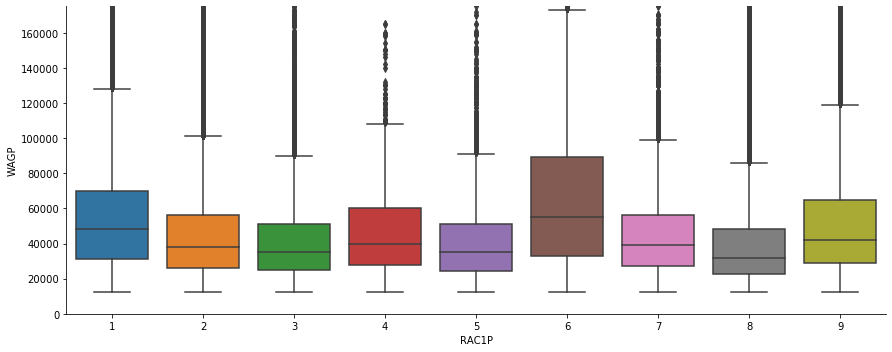

In [41]:
g = sns.catplot(y="WAGP", x="RAC1P", data=occ_test, kind="box", aspect=2.5)
g.set(ylim=(0, 175000))

In [42]:
occ_test['RAC1P'].value_counts()

1    4130212
2     468840
6     283418
8     184614
9      98429
3      34664
7       8488
5       6502
4       1461
Name: RAC1P, dtype: int64

In [43]:
def int_race_split(df):
    # split into occupational industries
    df['RAC1P'] = np.where(df['HISP'] == 1, df['RAC1P'], 10)
    df['RACE'] = df['RAC1P'].map(lambda y: "WHT" if y == 1  # white
                                 else "BLK" if y == 2  # black
                                 else "NTV" if y <= 5  # native
                                 else "ASN" if y == 6  # asian
                                 else "NTV" if y == 7  # native
                                 else "MIX" if y <= 9  # mixed
                                 else "HISP" if y == 10
                                 else 4)

    return df

In [44]:
int_race_test = occ_test.copy()
int_race_test = int_race_split(int_race_test)
print("RACE :", int_race_test.RACE.unique())

RACE : ['HISP' 'WHT' 'NTV' 'ASN' 'MIX' 'BLK']


In [45]:
int_race_test['RACE'].value_counts()

WHT     3688501
HISP     665989
BLK      456639
ASN      280378
MIX       81820
NTV       43301
Name: RACE, dtype: int64

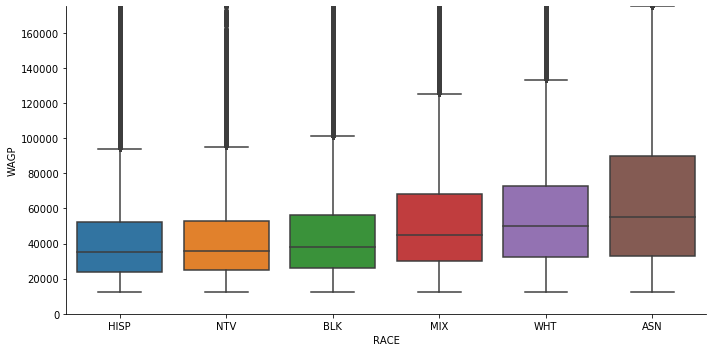

In [46]:
int_race_sort = int_race_test.groupby(
    'RACE').median().sort_values(by=['WAGP']).reset_index()
int_race_list = int_race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=int_race_test,
                kind="box", aspect=2, order=int_race_list)
g.set(ylim=(0, 175000))

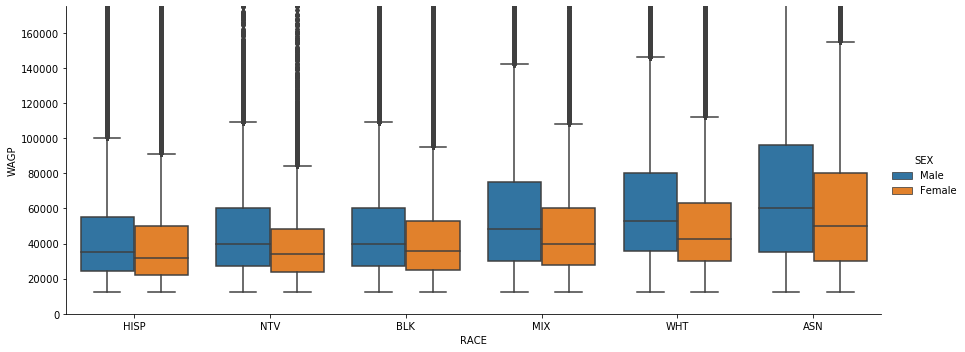

In [47]:
g = sns.catplot(y="WAGP", x="RACE", data=int_race_test, kind="box",
                aspect=2.5, hue="SEX", order =int_race_list)
g.set(ylim=(0, 175000))

In [48]:
def race_split(df):
    # split into occupational industries
    df['RAC1P'] = np.where(df['HISP'] == 1, df['RAC1P'], 10)
    df['RACE'] = df['RAC1P'].map(lambda y: 'WHT/MIX' if y == 1  # white
                                 else 'BLK' if y == 2  # black
                                 else 'HSP/NTV' if y <= 5  # native
                                 else 'ASN' if y == 6  # asian
                                 else 'HSP/NTV' if y == 7  # native
                                 else 'WHT/MIX' if y <= 9  # mixed
                                 else 'HSP/NTV' if y == 10 #hispanic
                                 else 'na')

    return df

In [49]:
race_test = occ_test.copy()
race_test = race_split(race_test)
print("RACE :", race_test.RACE.unique())

RACE : ['HSP/NTV' 'WHT/MIX' 'ASN' 'BLK']


In [50]:
race_test['RACE'].value_counts()

WHT/MIX    3770321
HSP/NTV     709290
BLK         456639
ASN         280378
Name: RACE, dtype: int64

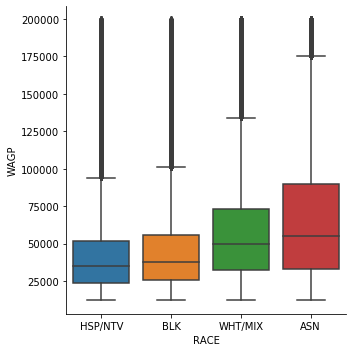

In [51]:
race_sort = race_test.groupby('RACE').median(
).sort_values(by=['WAGP']).reset_index()
race_list = race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=race_test,
                kind="box", order=race_list)

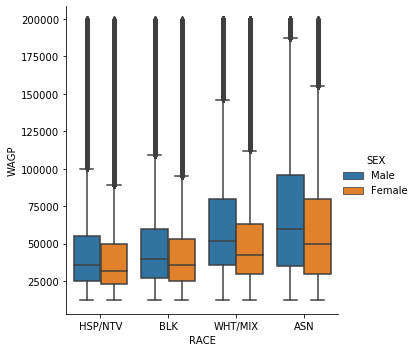

In [52]:
g = sns.catplot(y="WAGP", x="RACE", data=race_test, kind="box", hue="SEX", order=race_list)

## 3.4. State Observations
There was an interesting variable within the data stating the state which the person worked in. While it would have been simple if there was a trend in regions, but as observed, there is only a slight difference between each state due to the variation between each state. It still isn't clear what each stat's wage is, and it's difficult to extract the details needed to separate out each value.

Therefore, the general regions were used for each value, split between Northeast/Outlying Regions, West, Midwest, and South. While not too distinct, this separation should be sufficient.

In [53]:
int_state_sort = race_test.groupby('POWSP').median().reset_index()
int_state_sort['reg_code'] = ['3', '4', '4', '3', '4', '4', '1', '3', '3', '3',
                              '3', '4', '4', '2', '2', '2', '2', '3', '3', '1',
                              '3', '1', '2', '2', '3', '2', '4', '2', '4', '1',
                              '1', '4', '1', '3', '2', '2', '3', '4', '1', '1',
                              '3', '2', '3', '3', '4', '1', '3', '4', '3', '2',
                              '4', '5', '5', '5', '5', '5', '5', '5', '5', '5']
int_state_sort = int_state_sort.sort_values(by=['WAGP'])
int_state_list = int_state_sort['POWSP'].tolist()

In [54]:
reg_sort = int_state_sort.sort_values(by=['reg_code'])
reg_list = reg_sort['POWSP'].tolist()

In [55]:
ST_list = reg_sort['ST'].tolist()
print(ST_list)

[50.0, 9.0, 25.0, 34.0, 36.0, 44.0, 42.0, 23.0, 33.0, 38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0, 10.0, 48.0, 51.0, 24.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0, 35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0, 25.0, 26.0, 26.0, 34.0, 21.0, 48.0, 26.0, 32.0, 27.0]


In [56]:
print(reg_list)

[50.0, 9.0, 25.0, 34.0, 36.0, 44.0, 42.0, 23.0, 33.0, 38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0, 10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0, 35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0, 166.0, 399.0, 555.0, 72.0, 251.0, 303.0, 213.0, 254.0, 301.0]


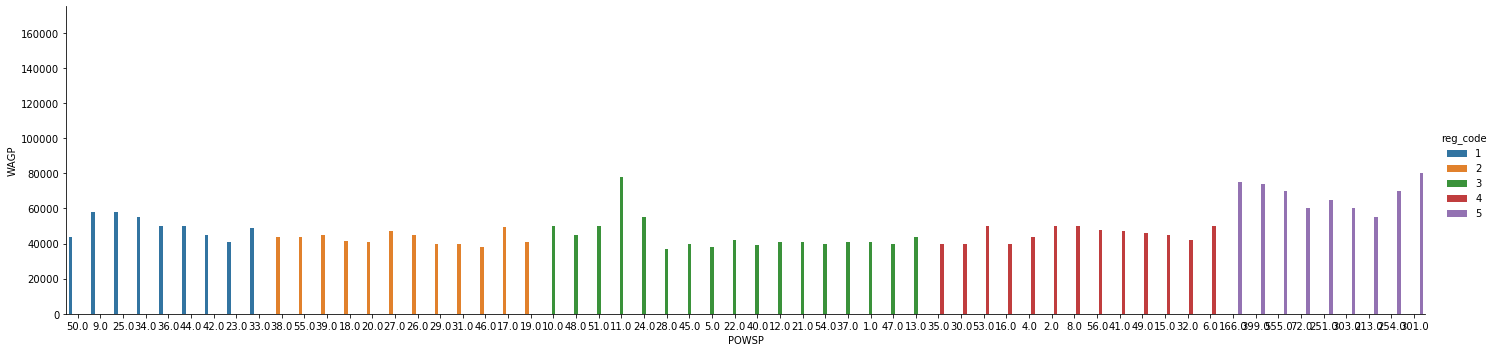

In [57]:
g = sns.catplot(y="WAGP", x="POWSP", hue='reg_code',
                data=reg_sort, kind="bar", aspect=4, order=reg_list)
g.set(ylim=(0, 175000))

In [58]:
int_state_sort.groupby('reg_code').median()

,POWSP,ST,AGEP,SCHL,WAGP,WKHP,WKW,HISP,OCCP,RAC1P
reg_code,,,,,,,,,,
1,34.0,34.0,45.0,20.0,50000.0,40.0,1.0,1.0,3930.0,1.0
2,28.0,28.0,45.0,19.0,42700.0,40.0,1.0,1.0,4700.0,1.0
3,24.0,24.0,44.0,19.0,41000.0,40.0,1.0,1.0,4520.0,1.0
4,30.0,30.0,44.0,19.0,46000.0,40.0,1.0,1.0,4220.0,1.0
5,254.0,26.0,46.0,20.0,70000.0,45.0,1.0,1.0,2640.0,1.0


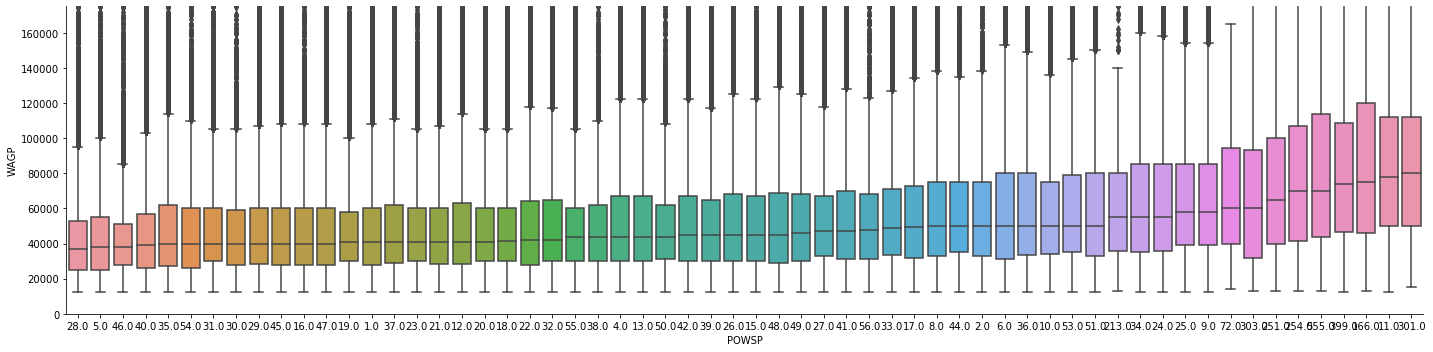

In [59]:
g = sns.catplot(y="WAGP", x="POWSP", data=race_test,
                kind="box", aspect=4, order=int_state_list)
g.set(ylim=(0, 175000))

In [60]:
print(int_state_list)

[28.0, 5.0, 46.0, 40.0, 35.0, 54.0, 31.0, 30.0, 29.0, 45.0, 16.0, 47.0, 19.0, 1.0, 37.0, 23.0, 21.0, 12.0, 20.0, 18.0, 22.0, 32.0, 55.0, 38.0, 4.0, 13.0, 50.0, 42.0, 39.0, 26.0, 15.0, 48.0, 49.0, 27.0, 41.0, 56.0, 33.0, 17.0, 8.0, 44.0, 2.0, 6.0, 36.0, 10.0, 53.0, 51.0, 213.0, 34.0, 24.0, 25.0, 9.0, 72.0, 303.0, 251.0, 254.0, 555.0, 399.0, 166.0, 11.0, 301.0]


In [61]:
def state_split(df):
    # split into higher paying regions (4 = Northeast/Outlying Regions, 3= West Coast, 2 = Midwest, 1 = South)
    df['STSP'] = df['POWSP'].map(lambda y: 4 if y in [50, 25.0, 9.0, 34.0, 36.0, 42.0, 44.0, 23.0, 33.0, 303.0, 166.0, 72.0, 251.0, 399.0, 301.0, 555.0, 254.0]
                                  else 3 if y in [35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0]
                                  else 2 if y in [38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0]
                                  else 1 if y in [10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0]
                                 else 5)
    test = df.loc[df['STSP'] == 5].copy()
    df = df.loc[df['STSP'] != 5].copy()
    test['STSP'] = test['ST'].map(lambda y: 4 if y in [50, 25.0, 9.0, 34.0, 36.0, 42.0, 44.0, 23.0, 33.0, 303.0, 166.0, 72.0, 251.0, 399.0, 301.0, 555.0, 254.0]
                                  else 3 if y in [35.0, 30.0, 53.0, 16.0, 4.0, 2.0, 8.0, 56.0, 41.0, 49.0, 15.0, 32.0, 6.0]
                                  else 2 if y in [38.0, 55.0, 39.0, 18.0, 20.0, 27.0, 26.0, 29.0, 31.0, 46.0, 17.0, 19.0]
                                  else 1 if y in [10.0, 48.0, 51.0, 11.0, 24.0, 28.0, 45.0, 5.0, 22.0, 40.0, 12.0, 21.0, 54.0, 37.0, 1.0, 47.0, 13.0]
                                  else 10)
    df = pd.concat([df, test])
    return df

In [62]:
state_test = race_test.copy()
state_test = state_split(state_test)
print("State :", state_test.STSP.unique())
state_test['STSP'].value_counts()

State : [3 2 1 4]


1    1960356
3    1177718
2    1159869
4     918685
Name: STSP, dtype: int64

In [63]:
state_sort = state_test.groupby(
    'STSP').median().sort_values(by=['WAGP']).reset_index()
state_list = state_sort['STSP'].tolist()

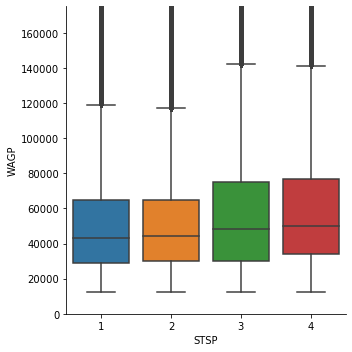

In [64]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test,
                kind="box", order=state_list)
g.set(ylim=(0, 175000))

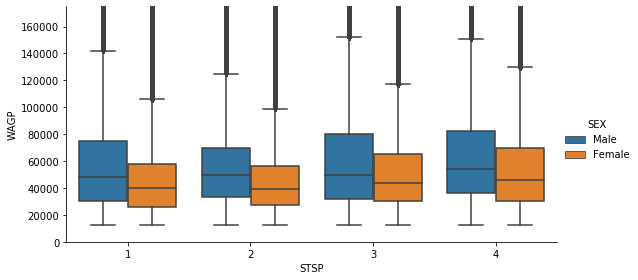

In [65]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test, kind="box",
                height=4, aspect=2, hue="SEX", order=state_list)
g.set(ylim=(0, 175000))

# 4. Dataframe Management
## 4.1. Remove Columns
With the data and feature mostly processed for all the values, the excess columns are removed to clean up the dataframes. The main columns to keep were those axis aimed to align upon, sex, age, education, race, region, and industry.

In [66]:
race_test.columns

Index(['ST', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'HISP', 'OCCP',
       'POWSP', 'RAC1P', 'AGEB', 'EDU', 'JOB', 'RACE'],
      dtype='object')

In [67]:
race_test.describe(include='all')

,ST,AGEP,SCHL,SEX,WAGP,WKHP,WKW,HISP,OCCP,POWSP,RAC1P,AGEB,EDU,JOB,RACE
count,5.216628e+06,5.216628e+06,5.216628e+06,5216628,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.053287e+06,5.216628e+06,5216628,5216628,5216628,5216628
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,6,10,4
top,NaN,NaN,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46-55,CLG,SAL,WHT/MIX
freq,NaN,NaN,NaN,3005886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1391659,1638229,1159118,3770321
mean,2.792770e+01,4.367315e+01,1.875502e+01,NaN,5.470252e+04,4.449304e+01,1.106981e+00,1.529659e+00,4.127022e+03,2.808633e+01,2.653488e+00,NaN,NaN,NaN,NaN
std,1.603593e+01,1.221741e+01,3.174406e+00,NaN,3.347824e+04,7.893772e+00,4.297612e-01,2.571809e+00,2.790060e+03,1.803378e+01,3.179572e+00,NaN,NaN,NaN,NaN
min,1.000000e+00,1.800000e+01,1.000000e+00,NaN,1.250000e+04,4.000000e+01,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN
25%,1.200000e+01,3.300000e+01,1.600000e+01,NaN,3.000000e+04,4.000000e+01,1.000000e+00,1.000000e+00,1.610000e+03,1.200000e+01,1.000000e+00,NaN,NaN,NaN,NaN
50%,2.700000e+01,4.400000e+01,1.900000e+01,NaN,4.500000e+04,4.000000e+01,1.000000e+00,1.000000e+00,4.220000e+03,2.700000e+01,1.000000e+00,NaN,NaN,NaN,NaN
75%,4.200000e+01,5.400000e+01,2.100000e+01,NaN,7.000000e+04,4.800000e+01,1.000000e+00,1.000000e+00,5.860000e+03,4.200000e+01,2.000000e+00,NaN,NaN,NaN,NaN


In [68]:
def remove_col(df):
    remove_cols = ['SCHL', 'WKHP', 'WKW', 'HISP',
                   'OCCP', 'POWSP', 'RAC1P', 'AGEP', 'ST']
    df = df.drop(remove_cols, axis=1)
    return df

In [69]:
remove_test = race_test.copy()
remove_test = remove_col(remove_test)
remove_test.describe(include='all')

,SEX,WAGP,AGEB,EDU,JOB,RACE
count,5216628,5.216628e+06,5216628,5216628,5216628,5216628
unique,2,NaN,5,6,10,4
top,Male,NaN,46-55,CLG,SAL,WHT/MIX
freq,3005886,NaN,1391659,1638229,1159118,3770321
mean,NaN,5.470252e+04,NaN,NaN,NaN,NaN
std,NaN,3.347824e+04,NaN,NaN,NaN,NaN
min,NaN,1.250000e+04,NaN,NaN,NaN,NaN
25%,NaN,3.000000e+04,NaN,NaN,NaN,NaN
50%,NaN,4.500000e+04,NaN,NaN,NaN,NaN
75%,NaN,7.000000e+04,NaN,NaN,NaN,NaN


## 4.2. OHE Columns
While it was ultimately decided that using OHE was not needed for the purposes of this model, but this section is showing how this would be achieved and implemented into the workflow. It works for the purposes of OHE each column and can be easily implemented.

In [70]:
def OHE_cat(df):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    cat_col = [i for i in df.columns.tolist() if i not in ['WAGP']]
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df[cat_col]))
    
    OHE_col = list(OH_encoder.get_feature_names(cat_col))
    OHE_col.insert(0, 'WAGP')
    
    OH_cols_train.index = df.index
    df = pd.concat([df, OH_cols_train], axis=1)
    df.drop(cat_col, axis=1, inplace=True)
    
    df.columns = OHE_col

    return df

In [71]:
OHE_test = remove_test.copy()
OHE_test = OHE_cat(OHE_test)
OHE_test.describe(include='all')

,WAGP,SEX_Female,SEX_Male,AGEB_18-25,AGEB_26-35,AGEB_36-45,AGEB_46-55,AGEB_56-70,EDU_BS,EDU_CLG,...,JOB_MTN,JOB_PRD,JOB_SAL,JOB_SCI,JOB_SVC,JOB_TRP,RACE_ASN,RACE_BLK,RACE_HSP/NTV,RACE_WHT/MIX
count,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,...,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06
mean,5.470252e+04,4.237876e-01,5.762124e-01,7.416247e-02,2.220431e-01,2.376184e-01,2.667737e-01,1.994024e-01,2.359329e-01,3.140398e-01,...,1.007009e-01,7.412106e-02,2.221968e-01,7.577213e-02,1.103376e-01,6.318066e-02,5.374698e-02,8.753528e-02,1.359671e-01,7.227506e-01
std,3.347824e+04,4.941576e-01,4.941576e-01,2.620351e-01,4.156200e-01,4.256242e-01,4.422731e-01,3.995511e-01,4.245805e-01,4.641324e-01,...,3.009323e-01,2.619678e-01,4.157228e-01,2.646332e-01,3.133101e-01,2.432876e-01,2.255177e-01,2.826179e-01,3.427537e-01,4.476407e-01
min,1.250000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.500000e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,7.000000e+04,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.990000e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# 5. Preprocessing Pipeline
Combining all the other steps, a pipeline was formed to easily test out a dataframe and transform it to the needs. Given its modular nature it's simple to change how each individual section acts without disturbing the whole notebook. Below outlines the data selection, feature transformation, and dataframe management sections.

In the graphs below, jobs, education, and age were compared against one another to see how wages correlates with wages and how much each feature affects one another. It’s observed that each of the values have a high correlation with wage and seems to be independently increasing wages, but also dependent on one another for the extent in which the wage varies.

In [72]:
def modeling_pipeline(df):
    df = (df
          .pipe(full_time_detect)
          .pipe(outlier_wage)
          .pipe(name_sexes)
          .pipe(age_bins)
          .pipe(edu_split)
          .pipe(occ_split)
          #.pipe(state_split)
          .pipe(race_split)
          .pipe(remove_col)
          .pipe(OHE_cat)
          )
    return df

In [73]:
def catagorical_pipeline(df):
    df = (df
          .pipe(full_time_detect)
          .pipe(outlier_wage)
          .pipe(name_sexes)
          .pipe(age_bins)
          .pipe(edu_split)
          .pipe(occ_split)
          #.pipe(state_split)
          .pipe(race_split)
          .pipe(remove_col)
          #.pipe(OHE_cat)
          )
    return df

In [74]:
start_time = time.time()
pp_test = PUS_start.copy()
pp_test = modeling_pipeline(pp_test)
print(" %s min" % round(((time.time() - start_time)/60), 2))
pp_test.describe(include='all')

 0.39 min


,WAGP,SEX_Female,SEX_Male,AGEB_18-25,AGEB_26-35,AGEB_36-45,AGEB_46-55,AGEB_56-70,EDU_BS,EDU_CLG,...,JOB_MTN,JOB_PRD,JOB_SAL,JOB_SCI,JOB_SVC,JOB_TRP,RACE_ASN,RACE_BLK,RACE_HSP/NTV,RACE_WHT/MIX
count,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,...,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06,5.216628e+06
mean,5.470252e+04,4.237876e-01,5.762124e-01,7.416247e-02,2.220431e-01,2.376184e-01,2.667737e-01,1.994024e-01,2.359329e-01,3.140398e-01,...,1.007009e-01,7.412106e-02,2.221968e-01,7.577213e-02,1.103376e-01,6.318066e-02,5.374698e-02,8.753528e-02,1.359671e-01,7.227506e-01
std,3.347824e+04,4.941576e-01,4.941576e-01,2.620351e-01,4.156200e-01,4.256242e-01,4.422731e-01,3.995511e-01,4.245805e-01,4.641324e-01,...,3.009323e-01,2.619678e-01,4.157228e-01,2.646332e-01,3.133101e-01,2.432876e-01,2.255177e-01,2.826179e-01,3.427537e-01,4.476407e-01
min,1.250000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.500000e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,7.000000e+04,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.990000e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# 6. Modeling
## 6.1. Random Forest
Below outlines how each the data was modeled. Since the modeling was used to be a comparative value, it wasn't necessarily finetuned for each parameter. Random forest regressor was used as a standard. Given how large the datafile is, it's difficult to fully fit and predict the dataset fully. Luckily, having more data isn't a problem.

The dataset was split accordingly to be able to tune some parameter and ultimately fit to a random forest regressor.

In [78]:
cv_split = pp_test.copy()
cv_split.shape
param_split = cv_split.sample(frac=0.05)
param_split.shape

(260831, 28)

In [79]:
param_y = param_split['WAGP']
param_x = param_split.drop(['WAGP'], axis=1)

In [80]:
kfold = StratifiedKFold(n_splits=3)

RFR = RandomForestRegressor()
rfr_param_grid = {'n_estimators': [50, 100],
                  'min_samples_split': [5, 10],
                  'min_samples_leaf': [10, 20]}

gsRFR = GridSearchCV(RFR, param_grid=rfr_param_grid, cv=kfold,
                     scoring="neg_mean_absolute_error", verbose=1, n_jobs=4)

gsRFR.fit(param_x, param_y)

RFR_best = gsRFR.best_estimator_

gsRFR.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  4.0min finished


-19328.542200842647

In [81]:
RFR_best

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [82]:
fit_split = cv_split.sample(frac=0.02)
fit_split.shape

(104333, 28)

In [83]:
y_full = fit_split['WAGP']
X_full = fit_split.drop(['WAGP'], axis=1)

In [84]:
CV_score = cross_val_score(RFR_best, X_full, y_full,
                scoring="neg_mean_absolute_error", cv=kfold, n_jobs=4, verbose=1)
print("CV_MAE: ", statistics.mean(CV_score))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CV_MAE:  -19462.670891373516


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   12.4s finished


## 6.2. Feature Selection
Overall, it's observed that education, occupational industry, and age are the main indicators or wage with sex follow up behind (region and race had minimal impact, but could have more value is more details were provided, or if the model was fit with an artificially higher ratio of minority races or if the states were separated more finely)

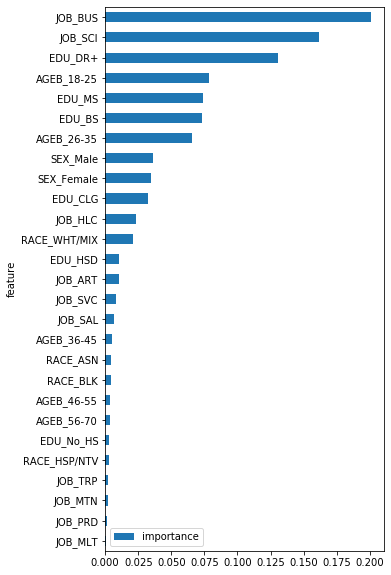

In [85]:
features = pd.DataFrame()
features['feature'] = X_full.columns
features['importance'] = RFR_best.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(5, 10))

# 7. Analysis
## 7.1. Scoring Rational
Below is the function to score a dataset for an individual year. It's extremely difficult to capture the total wage gap of the entire united states since each region, industry, education level has a different level of variance between men and woman. Therefore, to capture this information all in a single number is intimidating and difficult.

The core methodology was that (1) the score should encapsulate the entire US population so it should be weighted, (2) maintain sex separation between feature so male vs. female dominated industries don't have a bias, and (3) compare the values between true wages and predicted wages to determine if there's any significant differences.

Function commented below:

In [86]:
def keep_cat_cols(df):
    modeling_df = modeling_pipeline(df)
    catagorical_df = catagorical_pipeline(df)
    y_mod = modeling_df['WAGP']
    x_mod = modeling_df.drop(['WAGP'], axis=1)
    preds_test = RFR_best.predict(x_mod)
    predicted = pd.DataFrame({'Index': x_mod.index, 'WAG_pred': preds_test}).set_index('Index')
    org = pd.concat([predicted, catagorical_df], axis=1, sort=False)
    return org  

In [166]:
def score_ratio(df, var, base_cat):

#group as needed for each group
    grouped = df.groupby(['SEX', 'EDU', 'JOB', 'RACE', 'AGEB']) \
        .agg({'WAG_pred': ['mean'], 'WAGP': ['count', 'mean', 'std']}) \
        .unstack(fill_value=0).stack().reset_index()
    grouped.columns = grouped.columns.map('_'.join).str.strip('_')
    grouped['WAG'] = (grouped['WAG_pred_mean'] + grouped['WAGP_mean'])/2
    
    output_sep = []
    output_grp = []
    cat_list = list(df[var].unique())
    
    if var == 'SEX':
        f_cat = grouped[(grouped['SEX'] == 'Female')].reset_index()
        m_cat = grouped[(grouped['SEX'] == 'Male')].reset_index()

        temp = pd.DataFrame({'f_wage': f_cat.WAG, 'f_ct': f_cat.WAGP_count,
                            'm_wage': m_cat.WAG, 'm_ct': m_cat.WAGP_count})
        temp = temp.loc[(temp['f_ct'] >= 1) & (temp['m_ct'] >= 1)]

        temp['mx_wage'] = temp['m_wage'] * temp['m_ct'] / temp['m_ct'].sum()
        temp['fx_wage'] = temp['f_wage'] * temp['f_ct'] / temp['f_ct'].sum()
        temp['m_ratio'] = temp['m_wage'] / temp['m_wage'] * temp['m_ct'] / temp['m_ct'].sum()
        temp['f_ratio'] = temp['f_wage'] / temp['m_wage'] * temp['f_ct'] / temp['f_ct'].sum()
        m_ct = temp['m_ct'].sum()
        f_ct = temp['f_ct'].sum()
        m_ratio = round(temp['m_ratio'].sum(), 3)
        f_ratio = round(temp['f_ratio'].sum(), 3)
        m_wage = round(temp['mx_wage'].sum(), 3)
        f_wage = round(temp['fx_wage'].sum(), 3)
        m_summary = [var, 'Male', m_wage, m_ratio, 'Male', m_ct]
        f_summary = [var, 'Female', f_wage, f_ratio, 'Female', f_ct]
        output_sep.append(m_summary)
        output_sep.append(f_summary)
        
        t_ct = f_ct + m_ct
        diff = (m_wage - f_wage) / f_wage
        summary = [var, 'F/M', diff, t_ct, m_wage, m_ratio, m_ct, f_wage, f_ratio, f_ct]
        output_grp.append(summary)
        
    else:
        for n in cat_list:
            m_ncat = grouped[(grouped[var] == n) & (grouped['SEX'] == 'Male')].reset_index()
            f_ncat = grouped[(grouped[var] == n) & (grouped['SEX'] == 'Female')].reset_index()
            m_base = grouped[(grouped[var] == base_cat) & (grouped['SEX'] == 'Male')].reset_index()

            temp = pd.DataFrame({'m_cat_wage': m_ncat.WAG, 'm_cat_ct': m_ncat.WAGP_count,
                                 'f_cat_wage': f_ncat.WAG, 'f_cat_ct': f_ncat.WAGP_count,
                                'm_bas_wage': m_base.WAG, 'm_bas_ct': m_base.WAGP_count})
            temp = temp.loc[(temp['m_cat_ct'] >= 1) & (temp['f_cat_ct'] >= 1) & (temp['m_bas_ct'] >= 1)]

            temp['mx_wage'] = temp['m_cat_wage'] * temp['m_cat_ct'] / temp['m_cat_ct'].sum()
            temp['mx_ratio'] = temp['m_cat_wage'] / temp['m_bas_wage'] * temp['m_cat_ct'] / temp['m_cat_ct'].sum()
            m_ct = temp['m_cat_ct'].sum()
            m_wage = round(temp['mx_wage'].sum(), 3)
            m_ratio = round(temp['mx_ratio'].sum(), 3)
            m_summary = [var, n, m_wage, m_ratio, 'Male', m_ct]
            output_sep.append(m_summary)

            temp['fx_wage'] = temp['f_cat_wage'] * temp['f_cat_ct'] / temp['f_cat_ct'].sum()
            temp['fx_ratio'] = temp['f_cat_wage'] / temp['m_bas_wage'] * temp['f_cat_ct'] / temp['f_cat_ct'].sum()
            f_ct = temp['f_cat_ct'].sum()
            f_wage = round(temp['fx_wage'].sum(), 3)
            f_ratio = round(temp['fx_ratio'].sum(), 3)
            f_summary = [var, n, f_wage, f_ratio,'Female', f_ct]
            output_sep.append(f_summary)

            t_ct = f_ct + m_ct
            diff = (m_wage - f_wage) / f_wage
            summary = [var, n, diff, t_ct, m_wage, m_ratio, m_ct, f_wage, f_ratio, f_ct]
            output_grp.append(summary)
    
    output_sep = pd.DataFrame(output_sep, columns = ['Variable', 'Category', 'Wage', 'Ratio', 'Sex', 'Count'])
    output_grp = pd.DataFrame(output_grp, columns = ['Variable', 'Category', 'Percent_Difference', 'Total_Count',
                                                     'Male_Wage', 'Male_Ratio', 'Male_Count',
                                                     'Female_Wage', 'Female_Ratio', 'Female_Count'])
    
    return (output_sep, output_grp)

## 7.2. Feature Comparison
Each feature was compared with the get final score which was nomalized by comparing the values across all other features. The final results were graphically represented below with each feature.

In [139]:
year = '2018'
PUS_full = pd.DataFrame()
start_time = time.time()

useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
               'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST', 'HISP']
path = ('data/%s' % year)
PUS_split = pd.concat([pd.read_csv(f, usecols=useful_cols)
                       for f in glob.glob(path + "/*.csv")], ignore_index=True)
PUS_full = PUS_full.append(PUS_split)
PUS_df = keep_cat_cols(PUS_full)
print(PUS_full.shape, PUS_df.shape)
print(" %s min" % round(((time.time() - start_time)/60), 2))

(3061692, 11) (820235, 7)
 0.28 min


In [141]:
test_year = PUS_df.copy()

years = list(range(2013, 2019))
PUS_full = pd.DataFrame()
start_time = time.time()
for year in years:
    useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P',
                   'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST', 'HISP']
    path = ('data/%s' % year)
    PUS_split = pd.concat([pd.read_csv(f, usecols=useful_cols)
                           for f in glob.glob(path + "/*.csv")], ignore_index=True)
    PUS_full = PUS_full.append(PUS_split)
print(PUS_full.shape)
print(" %s min" % round(((time.time() - start_time)/60), 2))

In [157]:
catagories = [['SEX', 'Male'], ['AGEB', '26-35'], ['EDU', 'BS'],
           ['JOB', 'SAL'], ['RACE', 'WHT/MIX']]
sep_full = pd.DataFrame()
grp_full = pd.DataFrame()
for n in catagories:
    score_cat = score_ratio(PUS_df, n[0], n[1])    
    sep_full = pd.concat([sep_full, score_cat[0]])
    grp_full = pd.concat([grp_full, score_cat[1]])

In [158]:
sep_full

,Variable,Category,Wage,Ratio,Sex,Count
0,SEX,Male,57811.854,1.000,Male,438954.0
1,SEX,Female,47469.442,0.872,Female,345902.0
0,AGEB,26-35,50098.359,1.000,Male,97805.0
1,AGEB,26-35,43850.677,0.887,Female,75694.0
2,AGEB,46-55,64172.205,1.281,Male,121161.0
3,AGEB,46-55,50621.007,1.068,Female,99191.0
4,AGEB,36-45,61296.063,1.220,Male,112618.0
5,AGEB,36-45,50117.789,1.039,Female,83098.0
6,AGEB,18-25,31847.734,0.718,Male,30525.0
7,AGEB,18-25,29517.680,0.623,Female,22851.0


In [159]:
grp_full

,Variable,Category,Percent_Difference,Total_Count,Male_Wage,Male_Ratio,Male_Count,Female_Wage,Female_Ratio,Female_Count
0,SEX,F/M,0.217875,784856.0,57811.854,1.000,438954,47469.442,0.872,345902.0
0,AGEB,26-35,0.142476,173499.0,50098.359,1.000,97805,43850.677,0.887,75694.0
1,AGEB,46-55,0.267699,220352.0,64172.205,1.281,121161,50621.007,1.068,99191.0
2,AGEB,36-45,0.223040,195716.0,61296.063,1.220,112618,50117.789,1.039,83098.0
3,AGEB,18-25,0.078938,53376.0,31847.734,0.718,30525,29517.680,0.623,22851.0
4,AGEB,56-70,0.257429,140559.0,62813.694,1.237,76813,49954.087,1.075,63746.0
0,EDU,BS,0.290203,190451.0,72317.685,1.000,103646,56051.409,0.831,86805.0
1,EDU,CLG,0.295746,260310.0,53444.849,0.834,143339,41246.393,0.614,116971.0
2,EDU,HSD,0.297190,201452.0,44401.290,0.742,125655,34228.832,0.526,75797.0
3,EDU,No_HS,0.274620,47814.0,35127.805,0.650,32118,27559.435,0.472,15696.0


[(25000, 100000)]

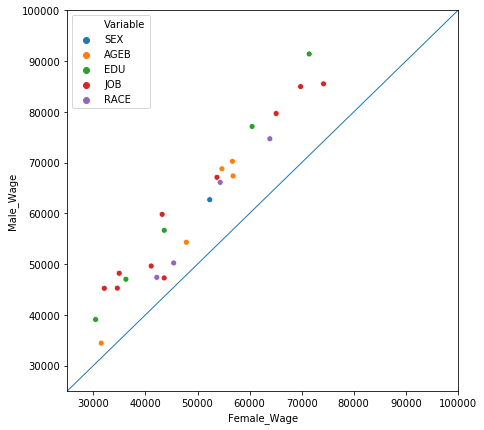

In [94]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x="Female_Wage", y="Male_Wage", hue="Variable",data=grp_full)
plt.plot([25000,105000], [25000,105000], linewidth=1)
plt.plot(figsize=(10,10))
ax.set(ylim=(25000, 100000))
ax.set(xlim=(25000, 100000))

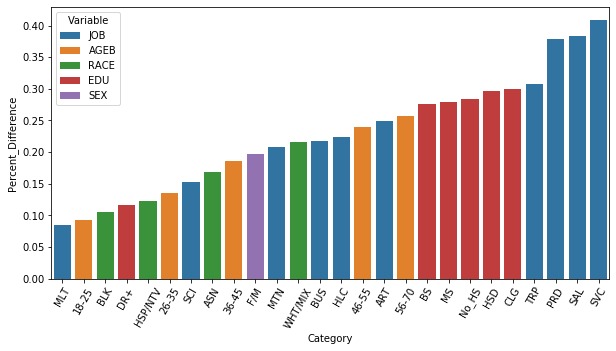

In [96]:
grp_full_sort = grp_full.sort_values(by=['Percent_Difference'])
grp_full_list = grp_full_sort['Category'].tolist()
plt.figure(figsize=(10,5))
plt.xticks(rotation=60)
g = sns.barplot(y="Percent_Difference", x="Category", dodge = False,
                hue='Variable', data=grp_full_sort)

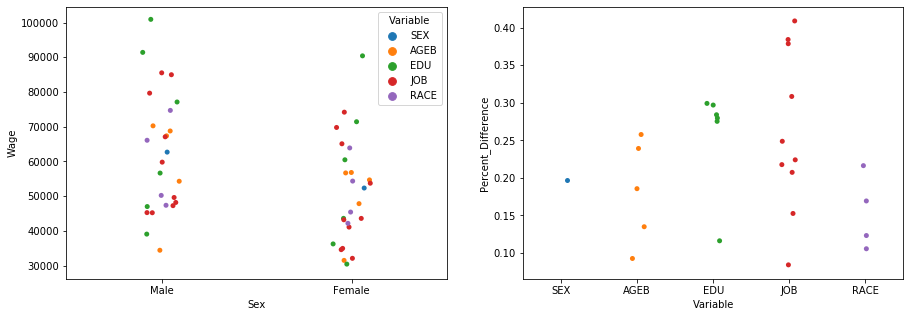

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.catplot(y="Wage", x='Sex',hue='Variable',kind="strip" , data=sep_full, ax=ax[0])
sns.catplot(y="Percent_Difference", x='Variable',kind="strip" , data=grp_full, ax=ax[1])
plt.close(2)
plt.close(3)

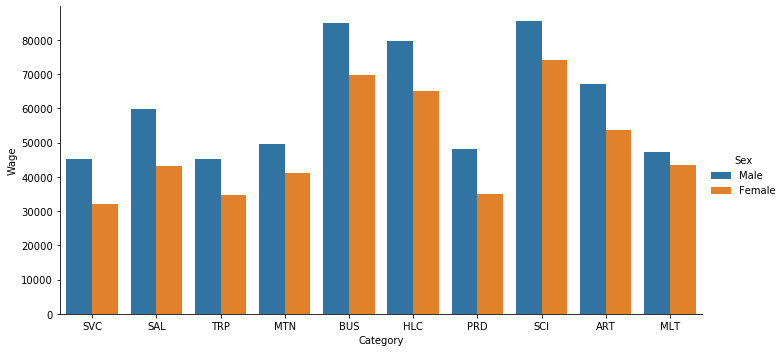

In [98]:
g = sns.catplot(data=sep_full.loc[(sep_full.Variable == 'JOB')],
                y='Wage', x='Category', hue='Sex', kind="bar", aspect=2)

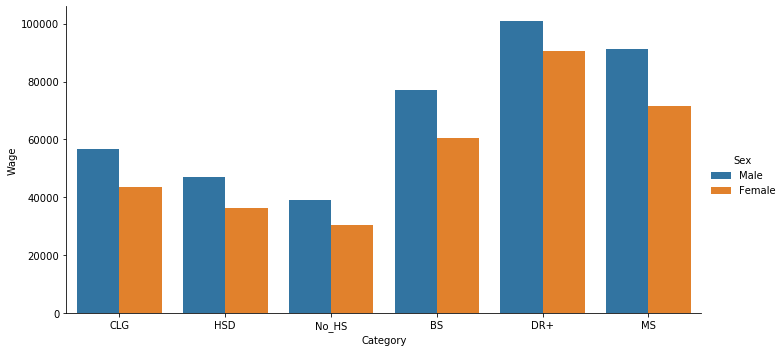

In [99]:
g = sns.catplot(data=sep_full.loc[(sep_full.Variable == 'EDU')],
                y='Wage', x='Category', hue='Sex', kind="bar", aspect=2)

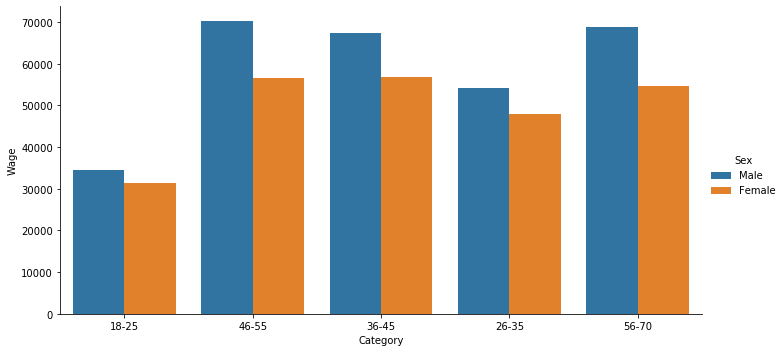

In [100]:
g = sns.catplot(data=sep_full.loc[(sep_full.Variable == 'AGEB')],
                y='Wage', x='Category', hue='Sex', kind="bar", aspect=2)

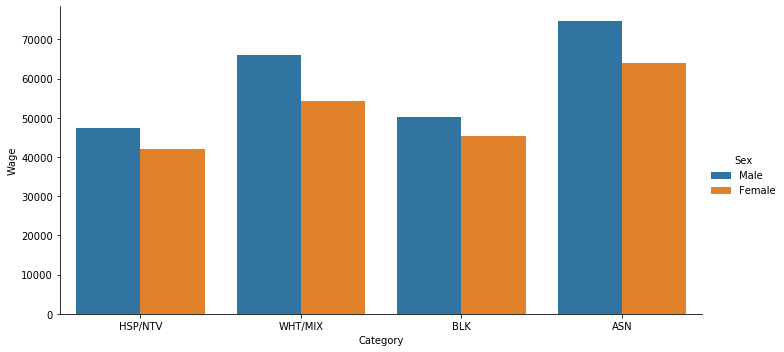

In [101]:
g = sns.catplot(data=sep_full.loc[(sep_full.Variable == 'RACE')],
                y='Wage', x='Category', hue='Sex', kind="bar", aspect=2)

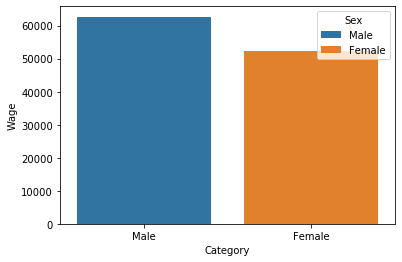

In [102]:
g = sns.barplot(data=sep_full.loc[(sep_full.Variable == 'SEX')],
                y="Wage", x="Category", dodge=False, hue='Sex')

## 7.2. Year to Year Analysis
With the function described prior, each year was individually scored to a dataframe which collected each score. The outputted dataframe took each ratio and averaged them to a single column which is graphed against each year. Unfortunately, output shows that there's minimal difference year to year of the wage gap shifting. One note is the standard deviations noted are not true standard deviations of the final scoring, rather just the std between all the unweighted ratios.

In [167]:
years = list(range(2008, 2019))
scores = pd.DataFrame()
start_time = time.time()
for year in years:
    useful_cols = ['WAGP', 'SEX', 'AGEP', 'RAC1P', 'HISP',
                   'SCHL', 'WKW', 'WKHP', 'OCCP', 'POWSP', 'ST']
    path = ('data/%s' % year)
    temp = pd.concat([pd.read_csv(f, usecols=useful_cols)
                      for f in glob.glob(path + "/*.csv")], ignore_index=True)
    score = score_ratio(keep_cat_cols(temp), 'SEX', 'Male')
    score_row = score[1]
    score_row['Year'] = year
    scores = pd.concat([scores, score_row])
    print("Completed :", year)

print(" %s min" % round(((time.time() - start_time)/60), 2))

Completed : 2008
Completed : 2009
Completed : 2010
Completed : 2011
Completed : 2012
Completed : 2013
Completed : 2014
Completed : 2015
Completed : 2016
Completed : 2017
Completed : 2018
 3.91 min


In [168]:
scores

,Variable,Category,Percent_Difference,Total_Count,Male_Wage,Male_Ratio,Male_Count,Female_Wage,Female_Ratio,Female_Count,Year
0,SEX,F/M,0.249493,942729.0,56228.467,1.0,522782,45001.042,0.800325,419947.0,2008
0,SEX,F/M,0.245597,908055.0,57208.204,1.0,498482,45928.350,0.802828,409573.0,2009
0,SEX,F/M,0.229181,859275.0,57268.981,1.0,460990,46591.185,0.813550,398285.0,2010
0,SEX,F/M,0.214204,841900.0,56534.023,1.0,451750,46560.555,0.823585,390150.0,2011
0,SEX,F/M,0.229548,883696.0,58006.584,1.0,485728,47177.149,0.813307,397968.0,2012
0,SEX,F/M,0.231432,904390.0,59071.117,1.0,496438,47969.465,0.812063,407952.0,2013
0,SEX,F/M,0.223324,924618.0,59466.908,1.0,511701,48610.927,0.817445,412917.0,2014
0,SEX,F/M,0.210478,929994.0,59663.805,1.0,509059,49289.463,0.826120,420935.0,2015
0,SEX,F/M,0.210587,938921.0,60556.719,1.0,511374,50022.602,0.826045,427547.0,2016
0,SEX,F/M,0.207461,997721.0,61124.841,1.0,552244,50622.620,0.828184,445477.0,2017


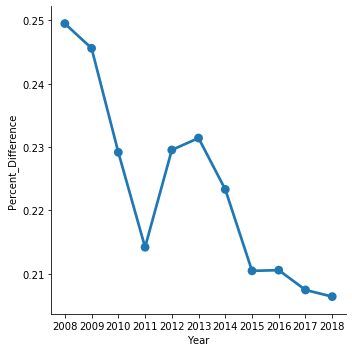

In [171]:
g = sns.catplot(y='Percent_Difference', x='Year', data=scores, kind='point')

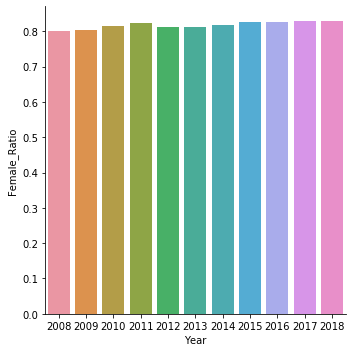

In [170]:
g = sns.catplot(y='Female_Ratio', x='Year', data=scores, kind='bar')

In [107]:
print ("2008 - 2018 Summary:")
print ("Average Wage % F/M: ", round(statistics.mean(scores["Female_Ratio"]),3))
print ("Stdev: ", round(statistics.stdev(scores["Female_Ratio"]),3))

2008 - 2018 Summary:
Average Wage % F/M:  0.836
Stdev:  0.026


## 7.3. Wage Predictor
Below is the read datafile for 2018 which allows a user of the notebook to input a set of conditions to the various features in order to display the median value under those conditions as well as a box and whisker plot of everyone falling under the specified set of categories. Given the low level of importance of the state and race features, they were excluded for this simple predictor.

In [ ]:
def df_isolate(df, sex, age, edu, job):
    wanted_df = df.loc[(df.SEX == sex) &
                             (df.AGEB == age) &
                             (df.EDU == edu) &
                             (df.JOB == job)
                             ].copy()
    return wanted_df

In [ ]:
Sex = int(input("""Enter gender:
            1 = Male
            2 = Female
            Entered: """))
Age = int(input("""Enter age bin:
            1 = 18-25
            2 = 26-35
            3 = 36-45 or 66-70
            4 = 46-65
            Entered: """))
Edu = int(input("""Enter level of education:
            1 = No HS or HS Equivalent
            2 = Some College or Associates
            3 = Bachelor’s Degree
            4 = Master’s Degree
            5 = Doctorate or Higher
            Entered: """))
Job = int(input("""Enter job industry:
            1 = Production, Service, Transportation
            2 = Military, Sales, Maintenance
            3 = Arts, Healthcare,
            4 = Science, Business
            Entered: """))

User_imput = df_isolate(test_PUS, Sex, Age, Edu, Job)
print("Total Matches: %s people" % User_imput.WAGP.count())
print("Median Wage: $",int(User_imput.WAGP.median()))
ax = sns.boxplot(x=User_imput["WAGP"])